In [3]:
!pip install python-mecab-ko

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.9/573.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 15.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from gensim.models import Word2Vec
from mecab import MeCab

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
mecab = MeCab()

데이터 불러오기
<br>
https://kli.korean.go.kr/corpus/member/memberSignUpChoose.do
<br>
<br>
일반적인 한국어 토크나이저 모델: mecab
<br>
https://pypi.org/project/python-mecab-ko/
<br>
<br>
심사 끝날때까지 수집했던 뉴스 데이터로 진행
<br>


---


<br>
mecab사용법

<br>


1.  mecab.morphs('영등포구청역에 있는 맛집 좀 알려주세요.') <br>
['영등포구청역', '에', '있', '는', '맛집', '좀', '알려', '주', '세요', '.']<br><br>
2.   mecab.nouns('우리나라에는 무릎 치료를 잘하는 정형외과가 없는가!')<br>
['우리', '나라', '무릎', '치료', '정형외과']<br><br>
3.   mecab.pos('자연주의 쇼핑몰은 어떤 곳인가?')<br>
[('자연주의', 'NNG'), ('쇼핑몰', 'NNG'), ('은', 'JX'), ('어떤', 'MM'), ('곳', 'NNG'), ('인가', 'VCP+EF'), ('?', 'SF')]<br>




Word2Vec으로 토큰화 된 단어 학습

In [ ]:
data = pd.read_csv('data_result.csv')
data.head(2)

,Word,Category
0,"['이수정', '배현진', '여자', '피해자', '수도', '우발', '사건', ...",5
1,"['외교부', '부부', '방북', '수교', '75', '주년', '교류', '확...",5


In [ ]:
X = data['Word']

# X 데이터를 리스트의 리스트로 변환
X_list_of_lists = [eval(word_list_str) for word_list_str in X]

# Word2Vec 모델 학습
model_w2v = Word2Vec(sentences=X_list_of_lists, vector_size=100, window=5, min_count=1, workers=4)

# 완성된 임베딩 매트릭스의 크기 확인
model_w2v.wv.vectors.shape

(9240, 100)

In [ ]:
# Word2Vec 모델에서 비슷한 단어 벡터 확인
print(model_w2v.wv.most_similar("대통령"))

[('트럼프', 0.9995162487030029), ('바이든', 0.9994646310806274), ('대선', 0.9992817044258118), ('공화당', 0.9990416765213013), ('대결', 0.999032735824585), ('미국', 0.9990307688713074), ('후보', 0.9990225434303284), ('윤석열', 0.9989741444587708), ('대한', 0.9989718794822693), ('대표', 0.9989666938781738)]


*   DBOW word2vec 모델 학습
*   Skip-gram word2vec 모델 학습

In [7]:
# 문장 토큰화 및 ID 부여 함수
def preprocess(text):
    # 토큰화
    mecab = MeCab()
    t = mecab.nouns(text) # 명사만 추출
    total_words = len(t) + 1

    word_to_id = {index: word for word, index in enumerate(t)}
    id_to_word = {v: k for k, v in word_to_id.items()}

    # 단어 목록을 단어 ID 목록으로 변환
    word_ids = [word_to_id[word] for word in t]

    # 단어 ID 목록을 넘파이 배열로 변환
    corpus = np.array(word_ids)
    return corpus, word_to_id, id_to_word

In [15]:
text = '한국어 토큰화를 진행하는 연습 문장입니다. 항상 차원의 크기를 잘 맞춰야 해요'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 5 6]
{'한국어': 0, '토큰': 1, '진행': 2, '연습': 3, '문장': 4, '차원': 5, '크기': 6}
{0: '한국어', 1: '토큰', 2: '진행', 3: '연습', 4: '문장', 5: '차원', 6: '크기'}


In [16]:
# ID를 기준으로 맥락과 타깃 생성 함수 작성
def create_contexts_target(corpus, window_size):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs=[]
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [17]:
# 맥락 타깃 생성
contexts, targets = create_contexts_target(corpus,window_size=1)
print(contexts.shape)
print(targets.shape)

# 원핫인코딩
total_words = len(corpus)

# 맥락과 타깃을 원핫인코딩
contexts_onehot = np.eye(total_words)[contexts]
targets_onehot = np.eye(total_words)[targets]

# 원핫인코딩 결과의 크기 출력
print("맥락의 크기 (원핫인코딩):", contexts_onehot.shape)
print("타깃의 크기 (원핫인코딩):", targets_onehot.shape)

(5, 2)
(5,)
맥락의 크기 (원핫인코딩): (5, 2, 7)
타깃의 크기 (원핫인코딩): (5, 7)


CBOW

Epoch [10/100], Loss: 0.8456
Epoch [20/100], Loss: 0.4555
Epoch [30/100], Loss: 0.2995
Epoch [40/100], Loss: 0.2199
Epoch [50/100], Loss: 0.1725
Epoch [60/100], Loss: 0.1414
Epoch [70/100], Loss: 0.1195
Epoch [80/100], Loss: 0.1033
Epoch [90/100], Loss: 0.0909
Epoch [100/100], Loss: 0.0811
Predicted: 1, Actual: 1


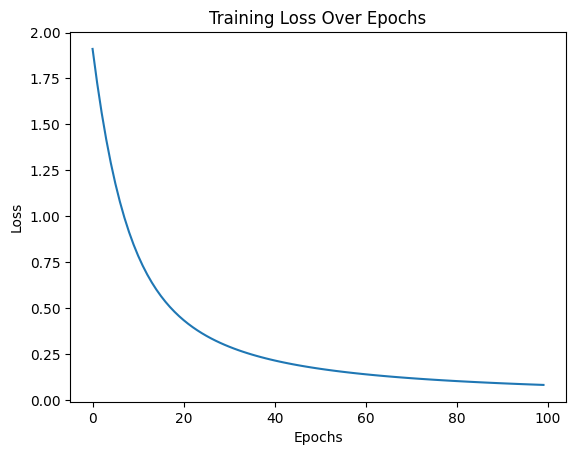

In [18]:
# 손실 기록 리스트
loss_history = []

# CBOW 모델 정의
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context):
        embedded = self.embeddings(context)
        summed = torch.sum(embedded, dim=1)
        output = self.linear(summed)
        return output

# Hyperparameters
vocab_size = len(np.unique(corpus))
embedding_dim = 50
learning_rate = 0.01
epochs = 100

# 모델 초기화
cbow_model = CBOWModel(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)

# 훈련
for epoch in range(epochs):
    inputs = torch.tensor(contexts, dtype=torch.long)
    labels = torch.tensor(targets, dtype=torch.long)

    optimizer.zero_grad()
    outputs = cbow_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 예측
with torch.no_grad():
    test_context = torch.tensor(contexts[0], dtype=torch.long).unsqueeze(0)
    predicted = cbow_model(test_context).argmax(dim=1).item()
    print(f'Predicted: {predicted}, Actual: {targets[0]}')

# 손실 그래프 시각화
plt.plot(loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

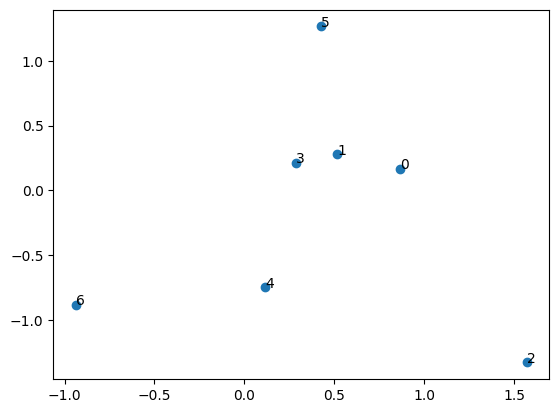

In [19]:
# 단어 임베딩 추출
word_embeddings = cbow_model.embeddings.weight.data.numpy()

# 시각화
for i, word in enumerate(np.unique(corpus)):
    plt.annotate(word, (word_embeddings[i, 0], word_embeddings[i, 1]))

plt.scatter(word_embeddings[:, 0], word_embeddings[:, 1])
plt.show()

Skip-gram

Epoch [10/100], Loss: 1.0889
Epoch [20/100], Loss: 0.9396
Epoch [30/100], Loss: 0.9090
Epoch [40/100], Loss: 0.8949
Epoch [50/100], Loss: 0.8867
Epoch [60/100], Loss: 0.8813
Epoch [70/100], Loss: 0.8775
Epoch [80/100], Loss: 0.8746
Epoch [90/100], Loss: 0.8724
Epoch [100/100], Loss: 0.8706
Predicted: 6, Actual: 4


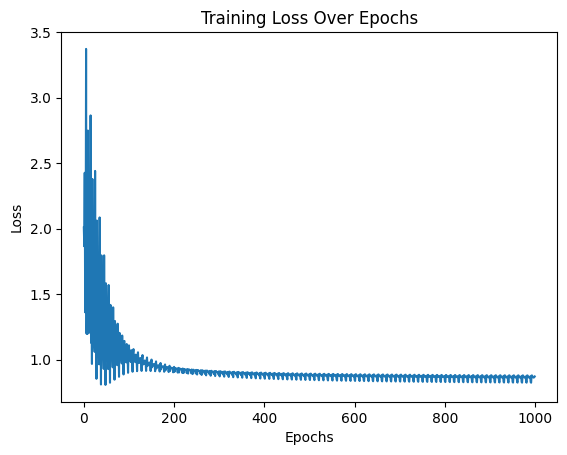

In [20]:
# 손실 기록 리스트
Skip_loss_history = []

# Skip-gram 모델 정의
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, target):
        embedded = self.embeddings(target)
        output = self.linear(embedded)
        return output

# Hyperparameters
vocab_size = len(np.unique(corpus))
embedding_dim = 50
learning_rate = 0.01
epochs = 100

# 모델 초기화
skipgram_model = SkipGramModel(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)

# 훈련
for epoch in range(epochs):
    for target, context in zip(targets, contexts):
        for ctx in context:
            target_tensor = torch.tensor([target], dtype=torch.long)
            context_tensor = torch.tensor([ctx], dtype=torch.long)

            optimizer.zero_grad()
            outputs = skipgram_model(target_tensor)
            loss = criterion(outputs, context_tensor)
            loss.backward()
            optimizer.step()
            Skip_loss_history.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 예측
with torch.no_grad():
    test_target = torch.tensor([targets[-1]], dtype=torch.long)  # 마지막 target을 사용
    predicted = skipgram_model(test_target).argmax(dim=1).item()
    print(f'Predicted: {predicted}, Actual: {contexts[-1][0]}')

# 손실 그래프 시각화
plt.plot(Skip_loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()